# SENTIMENT ANALYSIS

### We will first attempt a short sentiment analysis using the chat gpt API to have a testrun and establish an understanding of how sentiment analysis works as a group before continuing with our project on movie review sentiment analysis using pytorch

In [ ]:
# One way to perform sentiment analysis is by using the ChatGPT API
#But first you need to sign Up for the OpenAI API and Obtain an API Key. Replace the ""YOUR_API_KEY_HERE" with your actual API key
#pip install openai
#Create a Sentiment Analysis Prompt :
#Call the ChatGPT API for Sentiment Analysis


In [ ]:
import openai
openai.api_key = "YOUR_API_KEY_HERE"   #you need to put your api key here for it to work

text = "I am bullish on $AAPL"
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=(f"Sentiment analysis of the following text: '{text}'\n\nSentiment score: "),
    temperature=0,
    max_tokens=1
)

sentiment = response.choices[0].text.strip()
print(sentiment)



In [ ]:
#We can also code different scenarios based on our responses "Positive, Negative" using
# if sentiment == "Positive":
#     print("😊")
# elif sentiment == "Negative":
#     print("😔")
# else:
#     print("😐")

In [ ]:
#In the project above, we used the openai.Completion.create() method to send a prompt to the ChatGPT API.
#We're passing in the prompt we created earlier, along with several parameters that control how the API generates its response.
#After we send the request, we extract the sentiment from the response by taking the first choice in the response.choices list and removing any whitespace using the strip() method.


# The main project:


### Now that we understand what sentiment analysis is about, we will be creating a basic sentiment analysis classifier for movie reviews using the pytorch library for running the LSTM Neural network machine learning model.

### This classifier will determine whether user reviews express a positive, negative, or neutral sentiment. To accomplish this Python-based sentiment analysis project, we will leverage the IMDb movie review dataset. consisting of 50,000 global movie reviews. This dataset is designated for sentiment analysis and involves a binary classification task where reviews are labeled either positive or negative.

## Preparation of data
We use the field method of the data class to decide how data needs to be preprocessed. We also set the random seed to a certain number, which could be any but we mention it just for reproducibility purposes.

In [ ]:
#install the relevant libraries:
#pip install pandas, pip install numpy, pip install torch

#import sys
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import spacy

seed = 42

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

txt = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

labels = data.LabelField(dtype = torch.float)

Here we downloaded the imdb dataset for python sentiment analysis and divided it into train test and validation split. Then we further create a validation set from the train set.

We further limit the number of words the model will learn to 25000, this will choose the most used 25000 words from the dataset and use them for training. Significantly reducing the work of the model without any real loss in accuracy.

In [ ]:
train_data, test_data = datasets.IMDB.splits(txt, labels)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 26.6MB/s]


In [ ]:
train_data, valid_data = train_data.split(random_state = random.seed(seed))

In [ ]:
num_words = 25_000

txt.build_vocab(train_data,
                 max_size = num_words,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

labels.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.31MB/s]                           
100%|█████████▉| 398630/400000 [00:15<00:00, 25442.01it/s]

We are now creating a training, testing and validation batch from the data that we have for preparing it to be fed to the model in the form of batches of 64 samples at a time.

In [ ]:
btch_size = 64

train_itr, valid_itr, test_itr = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = btch_size,
    sort_within_batch = True,
    device = device)

## Defining python sentiment analysis model
To prepare the model and define its architecture, we are using a multi layer bidirectional rnn. We use nn.LSTM layers instead of normal nn.RNN layers to pass everything through an embedding layer which is just a representation of words in lower-dimensional space.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, word_limit, dimension_embedding, dimension_hidden, dimension_output, num_layers,
                 bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(word_limit, dimension_embedding, padding_idx = pad_idx)

        self.rnn = nn.LSTM(dimension_embedding,
                           dimension_hidden,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(dimension_hidden * 2, dimension_output)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, len_txt):


        embedded = self.dropout(self.embedding(text))


        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, len_txt.to('cpu'))

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)


        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.fc(hidden)


We define the parameters of the python sentiment analysis model and pass them to the model class instance just defined. The number of input parameters, the hidden layers, the output dimensions, and the throughput rate and bi-directionality booleans are defined. We also pass the pad token index from the vocabulary we created earlier.

In [ ]:
dimension_input = len(txt.vocab)
dimension_embedding = 100
dimension_hddn = 256
dimension_out = 1
layers = 2
bidirectional = True
droupout = 0.5
idx_pad = txt.vocab.stoi[txt.pad_token]

model = RNN(dimension_input,
            dimension_embedding,
            dimension_hddn,
            dimension_out,
            layers,
            bidirectional,
            droupout,
            idx_pad)

Now let's print some details of the model. Get the number of trainable parameters in the model.

We then obtain the pre-trained embedding weights and copy them into our model so that it doesn't need to learn the embeddings and can focus directly on the task at hand, which is to learn the sentiment associated with those embeddings.

The pre-trained embedding weights will replace the initial weights.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [ ]:
pretrained_embeddings = txt.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0650,  0.0029,  0.6209,  ..., -0.2100, -0.6873,  0.6438],
        [ 0.0766, -0.0666,  0.2242,  ..., -0.1401, -0.4067,  0.6296],
        [ 0.2527,  0.1215,  0.2966,  ..., -0.0253, -0.6011,  0.8194]])

In [ ]:
unique_id = txt.vocab.stoi[txt.unk_token]

model.embedding.weight.data[unique_id] = torch.zeros(dimension_embedding)
model.embedding.weight.data[idx_pad] = torch.zeros(dimension_embedding)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0650,  0.0029,  0.6209,  ..., -0.2100, -0.6873,  0.6438],
        [ 0.0766, -0.0666,  0.2242,  ..., -0.1401, -0.4067,  0.6296],
        [ 0.2527,  0.1215,  0.2966,  ..., -0.0253, -0.6011,  0.8194]])


Now, we want to define some parameters of the model, i.e. the optimiser we want to use and the loss criteria we need. In order to make the model converge quickly, we have chosen the adam optimiser and the logistic loss function.

## Training of the model

We now begin the necessary functions for training and evaluation of sentiment analysis model.

The first one is the binary accuracy function. We’ll use it for getting the accuracy of the model each time.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def bin_acc(preds, y):

    predictions = torch.round(torch.sigmoid(preds))
    correct = (predictions == y).float()
    acc = correct.sum() / len(correct)
    return acc

We define the function for training and evaluating the models. We start by looping through the number of epochs and the number of iterations in each epoch according to the batch size. Then we pass the text to the model, get the predictions from it, calculate the loss for each iteration and finally backward propagate that loss.

In [ ]:
def train(model, itr, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i in itr:

        optimizer.zero_grad()

        text, len_txt = i.text

        predictions = model(text, len_txt).squeeze(1)

        loss = criterion(predictions, i.label)

        acc = bin_acc(predictions, i.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(itr), epoch_acc / len(itr)

In [ ]:
def evaluate(model, itr, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for i in itr:

            text, len_txt = i.text

            predictions = model(text, len_txt).squeeze(1)

            loss = criterion(predictions, i.label)

            acc = bin_acc(predictions, i.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(itr), epoch_acc / len(itr)

We build a helper function epoch_time for calculating the time each epoch takes to complete its run and print it.  
We set the number of epochs to 5 and then begin our training.

In [ ]:
import time

def epoch_time(start_time, end_time):
    used_time = end_time - start_time
    used_mins = int(used_time / 60)
    used_secs = int(used_time - (used_mins * 60))
    return used_mins, used_secs

In [ ]:
num_epochs = 5

best_valid_loss = float('inf')

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_itr, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_itr, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|█████████▉| 398630/400000 [00:30<00:00, 25442.01it/s]

Epoch: 01 | Epoch Time: 0m 37s
	Train Loss: 0.658 | Train Acc: 60.15%
	 Val. Loss: 0.675 |  Val. Acc: 60.89%
Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 0.653 | Train Acc: 60.98%
	 Val. Loss: 0.606 |  Val. Acc: 68.85%
Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.490 | Train Acc: 77.06%
	 Val. Loss: 0.450 |  Val. Acc: 80.64%
Epoch: 04 | Epoch Time: 0m 40s
	Train Loss: 0.390 | Train Acc: 83.21%
	 Val. Loss: 0.329 |  Val. Acc: 86.56%
Epoch: 05 | Epoch Time: 0m 40s
	Train Loss: 0.321 | Train Acc: 86.95%
	 Val. Loss: 0.432 |  Val. Acc: 81.71%


## Testing sentiment analysis model

We load the saved checkpoint of the model and test it on the test set.

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_itr, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.343 | Test Acc: 85.83%


We can also check the model on the data. The model is trained to classify film reviews as positive, negative and neutral, so we will pass the relevant data to it for checking.

By defining another helper function that will print the sentiment of the comment based on the score that the model provides, we pass any data and test what does the model think about it.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def pred(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [txt.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
sent=["positive","neutral","negative"]
def print_sent(x):
  if (x<0.3): print(sent[0])
  elif (x>0.3 and x<0.7): print(sent[1])
  else: print(sent[2])

## Python Sentiment Analysis Output

In [ ]:
print_sent(pred(model, "This film was average"))


neutral


In [ ]:
print_sent(pred(model, "This film is horrible"))

negative


In [ ]:
print_sent(pred(model, "This film was great"))

positive


In [ ]:
print_sent(pred(model, "This was the best movie i have seen in a while. The cast was great and the script was awesome, and the direction just blew my mind"))

positive


In [ ]:
print_sent(pred(model, "the cast was dumb"))

negative


In [ ]:
print_sent(pred(model, "Why does this fil exist"))

negative


##### plotting the Test results against the validation results

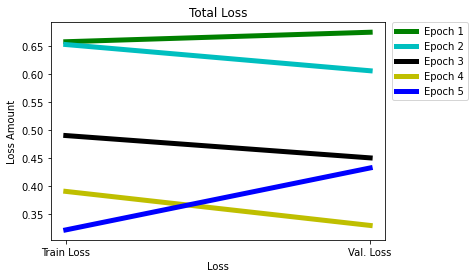

In [23]:
x = ['Train Loss', 'Val. Loss']
y1 = [0.658, 0.675]
y2 = [0.653, 0.606]
y3 = [0.490, 0.450]
y4 = [0.390, 0.329]
y5 = [0.321, 0.432]

plt.plot (x, y1, 'g', label='Epoch 1', linewidth=5) 
plt.plot (x, y2, 'c', label='Epoch 2', linewidth=5) 
plt.plot (x, y3, 'k',label='Epoch 3', linewidth=5) 
plt.plot (x, y4, 'y',label='Epoch 4', linewidth=5)
plt.plot(x,  y5, 'b', label='Epoch 5', linewidth=5)

plt.title('Total Loss')
plt.ylabel('Loss Amount' )
plt.xlabel('Loss')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    
    
    
   

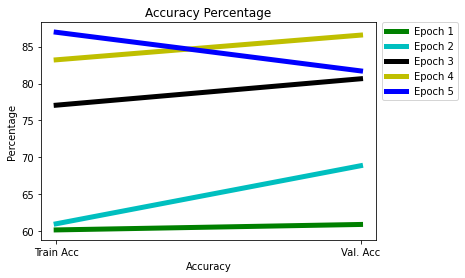

In [22]:
x = ['Train Acc', 'Val. Acc']

y1 = [60.15, 60.89]
y2 = [60.98, 68.85]
y3 = [77.06, 80.64]
y4 = [83.21, 86.56]
y5 = [86.95, 81.71]

plt.plot (x, y1, 'g', label='Epoch 1', linewidth=5) 
plt.plot (x, y2, 'c', label='Epoch 2', linewidth=5)
plt.plot (x, y3, 'k', label='Epoch 3', linewidth=5)
plt.plot (x, y4, 'y', label='Epoch 4', linewidth=5) 
plt.plot (x, y5, 'b', label='Epoch 5', linewidth=5)
plt.title('Accuracy Percentage')
plt.ylabel('Percentage') 
plt.xlabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Summary

We have successfully developed a Python Sentiment Analysis model based on lstm technique which is very robust and accurate. As discussed earlier, there are many use cases for sentiment analysis and we can use it as per the need. Similarly, we can change the dataset and train it on any other type of data as required. We can use this sentiment analysis model in every possible way.